# In this file we calibrate the Heston model through the direct image based approach
This is a one-step approach meaning that we don't go through the forward pass where we learn the **mapping** between **Heston parameters** and the entire implied volatility **surface**, which in this case is on a fixed grid 8(maturities)x11(strikes). Instead here we train the network only for the calibration purpose, switching input and output in the forward pass, this way we can immediately perform the calibration with a single evalutaion of the network: no posterior optimization required.
Below we upload the dataset .

In [1]:
#Set the directory of stored dataset
import os
os.chdir("C:/Users/pc/Desktop/politecnico/TESI/mio codice/Heston/grid based")

In [2]:
#import libraries
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
#Open compressed dataset

f = gzip.GzipFile('HestonTrainSet.txt.gz', "r")
dat=np.load(f) #load data in a numpy array
xx=dat[:,:5]   #extract first 5 columns (Heston parameters)
yy=dat[:,5:]   #extract last  columns ()

#define strikes and maturities
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

# Print shapes with descriptive messages
print("Shape of the full dataset (samples × (parameters + implied_vols)):", dat.shape)
print("\nInput (Heston parameter sets) shape (samples × 5 parameters):", xx.shape)
print("  - Each row contains: [ν₀, ρ, γ, θ, κ]")
print("\nTarget (Implied Volatility Surfaces) shape (samples × (maturities × strikes)):", yy.shape)
print(f"  - Each row represents a {len(maturities)}×{len(strikes)} grid (maturities × strikes)")  

Shape of the full dataset (samples × (parameters + implied_vols)): (12000, 93)

Input (Heston parameter sets) shape (samples × 5 parameters): (12000, 5)
  - Each row contains: [ν₀, ρ, γ, θ, κ]

Target (Implied Volatility Surfaces) shape (samples × (maturities × strikes)): (12000, 88)
  - Each row represents a 8×11 grid (maturities × strikes)


# Let's have a look at the dataset and gain some more informations


=== HESTON PARAMETERS ANALYSIS (xx) ===
       ν₀ (initial variance)  ρ (spot-vol correlation)  γ (vol of variance)  \
count             12000.0000                12000.0000           12000.0000   
mean                  0.0174                   -0.3479               0.6606   
std                   0.0121                    0.2078               0.3311   
min                   0.0001                   -0.9498               0.0100   
1%                    0.0002                   -0.9146               0.0170   
5%                    0.0006                   -0.7903               0.0438   
50%                   0.0163                   -0.2810               0.8011   
95%                   0.0375                   -0.1169               0.9846   
99%                   0.0395                   -0.1036               0.9972   
max                   0.0400                   -0.1000               1.0000   

       θ (mean reverting level of variance)  κ (speed of mean reversion)  
count         

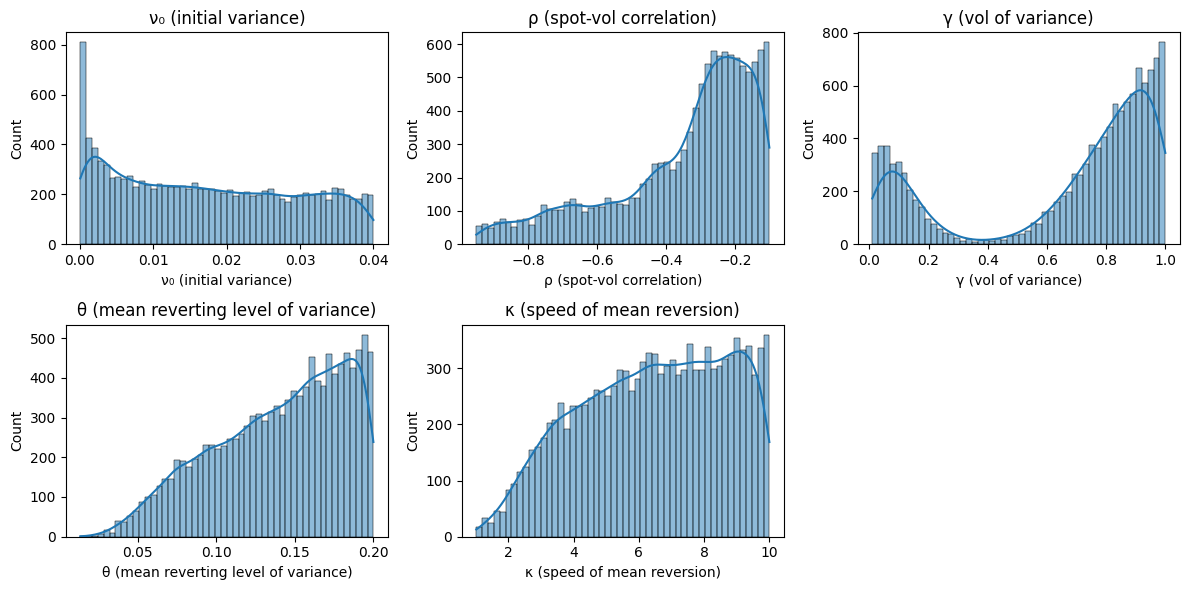


=== IMPLIED VOLATILITY SURFACE ANALYSIS (yy) ===
Global mean: 0.3220
Global min: 0.0845
Global max: 0.5618

Volatility matrix for strikes/maturities (first sample):
        0.5     0.6     0.7     0.8     0.9     1.0     1.1     1.2     1.3  \
0.1  0.3513  0.3213  0.2948  0.2729  0.2590  0.2582  0.2694  0.2852  0.3014   
0.3  0.3629  0.3489  0.3395  0.3346  0.3336  0.3357  0.3399  0.3455  0.3517   
0.6  0.3730  0.3687  0.3667  0.3664  0.3672  0.3689  0.3711  0.3737  0.3765   
0.9  0.3796  0.3783  0.3780  0.3785  0.3794  0.3807  0.3822  0.3838  0.3856   
1.2  0.3842  0.3839  0.3842  0.3848  0.3857  0.3867  0.3878  0.3890  0.3902   
1.5  0.3874  0.3875  0.3880  0.3887  0.3894  0.3903  0.3912  0.3921  0.3930   
1.8  0.3898  0.3901  0.3906  0.3913  0.3920  0.3927  0.3934  0.3942  0.3949   
2.0  0.3911  0.3915  0.3920  0.3926  0.3932  0.3939  0.3946  0.3952  0.3959   

        1.4     1.5  
0.1  0.3167  0.3307  
0.3  0.3583  0.3648  
0.6  0.3794  0.3824  
0.9  0.3873  0.3891  
1.2  0.3915 

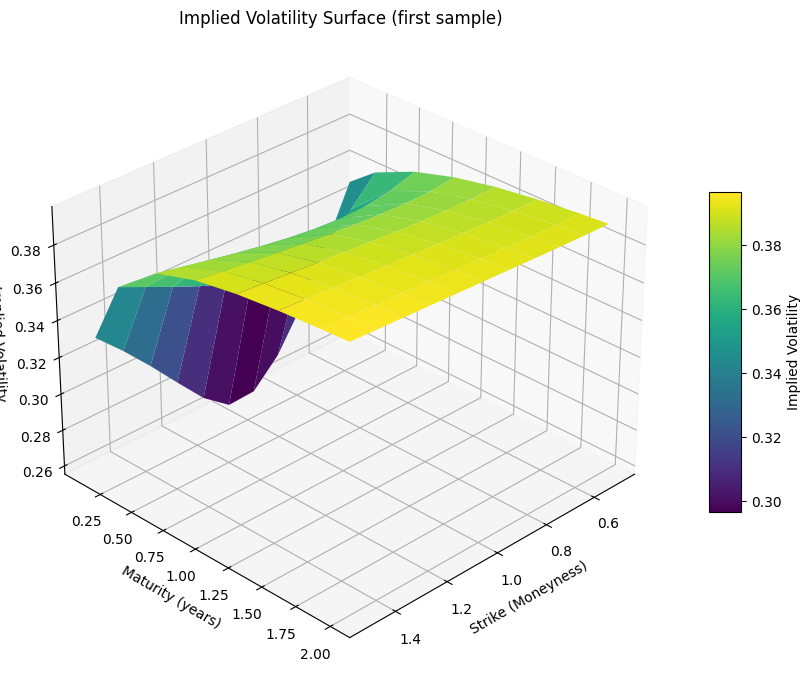

In [3]:
import seaborn as sns

#INPUT (HESTON PARAMETERS) ANALYSIS 

# Heston parameter names (for clarity)
#v0    ∈ [0.0001, 0.04]        (initial variance)
#rho   ∈ [-0.95, -0.1]         (spot-vol correlation)
#gamma ∈ [0.01, 1.0]           (vol of variance)
#theta ∈ [0.01, 0.2]           (mean reverting level of variance)
#kappa ∈ [1, 10.0]             (speed of mean reversion)
param_names = [
    'ν₀ (initial variance)',
    'ρ (spot-vol correlation)',
    'γ (vol of variance)',
    'θ (mean reverting level of variance)',
    'κ (speed of mean reversion)',
]

# Create DataFrame for statistical analysis
df_xx = pd.DataFrame(xx, columns=param_names)

# Descriptive statistics
print("\n=== HESTON PARAMETERS ANALYSIS (xx) ===")
print(df_xx.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).round(4))

# Validate physical bounds
print("\n=== PHYSICAL BOUNDS ===")
print(f"ν₀:    Min={df_xx.iloc[:,0].min():.4f}, Max={df_xx.iloc[:,0].max():.4f} (Expected: ~[0.0001, 0.04])")
print(f"ρ:   Min={df_xx.iloc[:,1].min():.4f}, Max={df_xx.iloc[:,1].max():.4f} (Expected: ~[-0.95, -0.1])")
print(f"κ: Min={df_xx.iloc[:,4].min():.4f}, Max={df_xx.iloc[:,4].max():.4f} (Expected: ~[1, 10])")

# Plot distributions
plt.figure(figsize=(12, 6))
for i, col in enumerate(df_xx.columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_xx[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

#OUTPUT (IMPLIED VOLATILTY SURFACE) ANALYSIS 
print("\n=== IMPLIED VOLATILITY SURFACE ANALYSIS (yy) ===")

# Global statistics
print(f"Global mean: {yy.mean():.4f}")
print(f"Global min: {yy.min():.4f}")
print(f"Global max: {yy.max():.4f}")

# Reshape first sample into strike/maturity matrix
vol_matrix = yy[0].reshape(len(maturities), len(strikes))
df_vol = pd.DataFrame(vol_matrix, index=maturities, columns=strikes)

print("\nVolatility matrix for strikes/maturities (first sample):")
print(df_vol.round(4))

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create grid for surface plot
X, Y = np.meshgrid(strikes, maturities)

# Plot surface
surf = ax.plot_surface(X, Y, vol_matrix, cmap='viridis', edgecolor='none')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Implied Volatility')

# Set labels and title
ax.set_xlabel('Strike (Moneyness)')
ax.set_ylabel('Maturity (years)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface (first sample)')

# Adjust view angle for better visualization
ax.view_init(30, 45)

# Adjust layout to prevent clipping
plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

plt.show()

# Step 1: Data Generation

## **Inputs:**
### Implied volatility surface (8x11=88 points)

## **Outputs:** 
###  1. $\nu_{0}$ inital variance
###  2. $\rho$ spot-vol correlation
###  3. $\gamma$ vol of variance
###  4. $\theta$ mean reverting level of variance
###  5. $\kappa$ speed of mean reversion 

# Scaling:

# Output Model Parameters ${\theta}_{i=1,..,5}\to scale(\theta_i)\in[-1,1]$ (suitable for tanh activation)
## $scale(\theta_i)=\frac{2\theta_i-(\theta_i^{max}+\theta_i^{min})}{\theta_i^{max}-\theta_i^{min}},\quad i \in |\Theta|$

# Implied volatilities input scaling
## $$scale(\sigma^{BS}_{i,j})=\frac{\sigma^{BS}_{i,j}-\mathbb{E}[\sigma^{BS}_{i,j}]}{std(\sigma^{BS}_{i,j})},\quad i\in\text{Maturities},\; j\in \text{Strikes}$$

In [4]:
#Train+val(90%)-test(10%) split of data 
from sklearn.model_selection import train_test_split
from tabulate import tabulate

y_train_val, y_test, X_train_val, X_test = train_test_split(
    xx, yy, test_size=0.1, random_state=42)

#Train(85%)-val(15%) split of data 
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.11, random_state=42)

#data preprocessing (scaling)
from sklearn.preprocessing import StandardScaler

#1- Apply standard (z-score) scaling to input volatilities
#  to train, validation and test data (clearly without recomputing mu and sigma for validation and test data)
scaler_X = StandardScaler()
x_train_transform = scaler_X.fit_transform(X_train)  #we compute mu and sigma
x_val_transform = scaler_X.transform(X_val)  
x_test_transform = scaler_X.transform(X_test)

#define the inverse transform of data to bring volatilities back to original values
def Xinversetransform(x):
    return scaler_X.inverse_transform(x)

#2-Custom [-1,1] parameter scaling, define Heston parameter's upper and lower bounds
#v0    ∈ [0.0001, 0.04]        (initial variance)
#rho   ∈ [-0.95, -0.1]         (spot-vol correlation)
#gamma ∈ [0.01, 1.0]           (vol of variance)
#theta ∈ [0.01, 0.2]           (mean reverting level of variance)
#kappa ∈ [1, 10.0]             (speed of mean reversion)
#parameters order is: [v0, rho, gamma, theta, kappa]

ub=np.array([0.04,-0.1,1.0,0.2,10.0])
lb=np.array([0.0001,-0.95,0.01,0.01,1])

#define the direct and inverse map (as described above)
def myscale(x):
    res=np.zeros(x.shape)
    for i in range(x.shape[1]):
        res[:,i]=(2*x[:,i] - (ub[i] + lb[i])) / (ub[i] - lb[i])
        
    return res

def myinverse(x):
    res=np.zeros(x.shape)
    for i in range(x.shape[1]):
        res[:,i]=x[:,i] * (ub[i] - lb[i]) * 0.5 + (ub[i] + lb[i]) * 0.5
        
    return res

#scale parameters in training, validation and test set
y_train_transform = myscale(y_train)
y_val_transform = myscale(y_val)
y_test_transform = myscale(y_test)

# Print dataset shapes in a table
shape_data = [
    ["Training", x_train_transform.shape, y_train_transform.shape],
    ["Validation", x_val_transform.shape, y_val_transform.shape],
    ["Test", x_test_transform.shape, y_test_transform.shape]
]

print("\nDataset Shapes Summary:")
print(tabulate(shape_data, 
               headers=["Dataset", "Input Surfaces Shape", "Target Parameters Shape"],
               tablefmt="grid"))


Dataset Shapes Summary:
+------------+------------------------+---------------------------+
| Dataset    | Input Surfaces Shape   | Target Parameters Shape   |
+============+========================+===========================+
| Training   | (9612, 88)             | (9612, 5)                 |
+------------+------------------------+---------------------------+
| Validation | (1188, 88)             | (1188, 5)                 |
+------------+------------------------+---------------------------+
| Test       | (1200, 88)             | (1200, 5)                 |
+------------+------------------------+---------------------------+


# Let's see if the scaling has been correctly applied

In [5]:
# ----------------------------------------------------------------------------------
# 1. Verify INPUT Scaling (X: Implied Volatilities - StandardScaler)
# ----------------------------------------------------------------------------------
def check_X_scaling(X_train, X_val, X_test, x_train_transform, x_val_transform, x_test_transform):
    # Calculate statistics for each set
    stats_train = {
        "Set": "Train",
        "Mean": np.mean(x_train_transform, axis=0).round(3)[0],
        "Std": np.std(x_train_transform, axis=0).round(3)[0],
        "Min": np.min(x_train_transform).round(3),
        "Max": np.max(x_train_transform).round(3),
        "Inverse Check": np.allclose(X_train, Xinversetransform(x_train_transform))
    }
    
    stats_val = {
        "Set": "Validation",
        "Mean": np.mean(x_val_transform, axis=0).round(3)[0],
        "Std": np.std(x_val_transform, axis=0).round(3)[0],
        "Min": np.min(x_val_transform).round(3),
        "Max": np.max(x_val_transform).round(3),
        "Inverse Check": np.allclose(X_val, Xinversetransform(x_val_transform))
    }
    
    stats_test = {
        "Set": "Test",
        "Mean": np.mean(x_test_transform, axis=0).round(3)[0],
        "Std": np.std(x_test_transform, axis=0).round(3)[0],
        "Min": np.min(x_test_transform).round(3),
        "Max": np.max(x_test_transform).round(3),
        "Inverse Check": np.allclose(X_test, Xinversetransform(x_test_transform))
    }
    
    # Create table
    df_X = pd.DataFrame([stats_train, stats_val, stats_test])
    print("\n=== IMPLIED VOLATILITIES SCALING (StandardScaler) ===")
    print(tabulate(df_X, headers='keys', tablefmt='pretty', showindex=False))

# ----------------------------------------------------------------------------------
# 2. Verify OUTPUT Scaling (yy: Heston Parameters - Custom [-1,1])
# ----------------------------------------------------------------------------------
def check_yy_scaling(y_train, y_val, y_test, y_train_transform, y_val_transform, y_test_transform):
    # Parameter names
    param_names = ["ν₀", "ρ", "γ", "θ", "κ"]
    
    # Calculate min/max after scaling and check bounds
    data = {
        "Parameter": param_names,
        "Original Min": [y_train[:,i].min().round(4) for i in range(5)],
        "Original Max": [y_train[:,i].max().round(4) for i in range(5)],
        "Scaled Min (Train)": [y_train_transform[:,i].min().round(4) for i in range(5)],
        "Scaled Max (Train)": [y_train_transform[:,i].max().round(4) for i in range(5)],
    }
    
    df_yy = pd.DataFrame(data)
    print("\n=== HESTON PARAMETERS SCALING (Custom [-1,1]) ===")
    print(tabulate(df_yy, headers='keys', tablefmt='pretty', showindex=False))
    
    print("\n=== VERIFY INVERSE TRANSFORMATION OF SCALED HESTON PARAMETERS (xx) ===")
    print(f"Train: {np.allclose(y_train, myinverse(y_train_transform))}")
    print(f"Val:   {np.allclose(y_val, myinverse(y_val_transform))}")
    print(f"Test:  {np.allclose(y_test, myinverse(y_test_transform))}")

    # Global check: All scaled values must be in [-1, 1]
    assert np.all(y_train_transform >= -1) and np.all(y_train_transform <= 1), "Some values are outside [-1,1]!"
    print("\n✔ All scaled parameters are within [-1,1]")

# ----------------------------------------------------------------------------------
# Run checks
# ----------------------------------------------------------------------------------
check_yy_scaling(y_train, y_val, y_test, y_train_transform, y_val_transform, y_test_transform)
check_X_scaling(X_train, X_val, X_test, x_train_transform, x_val_transform, x_test_transform)


=== HESTON PARAMETERS SCALING (Custom [-1,1]) ===
+-----------+--------------+--------------+--------------------+--------------------+
| Parameter | Original Min | Original Max | Scaled Min (Train) | Scaled Max (Train) |
+-----------+--------------+--------------+--------------------+--------------------+
|    ν₀     |    0.0001    |     0.04     |        -1.0        |       0.9996       |
|     ρ     |   -0.9487    |   -0.1001    |       -0.997       |       0.9999       |
|     γ     |     0.01     |     1.0      |        -1.0        |       0.9999       |
|     θ     |    0.0133    |     0.2      |      -0.9654       |        1.0         |
|     κ     |    1.0177    |    9.9986    |      -0.9961       |       0.9997       |
+-----------+--------------+--------------+--------------------+--------------------+

=== VERIFY INVERSE TRANSFORMATION OF SCALED HESTON PARAMETERS (xx) ===
Train: True
Val:   True
Test:  True

✔ All scaled parameters are within [-1,1]

=== IMPLIED VOLATILITIE

# CaNN: Calibration Neural Network
Now we can directly train the network to **calibrate** the Heston parameters, learning the mapping from: implied volatility surface -> Heston parameters. We can set up our neural network composed of:

- **4 hidden layers**, each with **30 neurons**  
- **output layer** with 5 neurons (parameters space dimension), here we select a **tanh** activation function since we scaled the parameters into [-1,1] interval
- **Activation function**: **Elu** , $\sigma_{Elu}=\alpha(e^x -1)$ in all the layers, its smoothness is crucial for the approximation of the Loss function
- **Batch size**: **256**  
- **Optimizer**: **Adam**  
- **Early stopping**: with patience set to 40 epochs
- **Loss**: MSE

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Set precision to float64
tf.keras.backend.set_floatx('float64')
tf.random.set_seed(42)  # For consistent initialization

# Build the model
inputs = Input(shape=(88,), name='input_layer')
x1 = Dense(30, activation='elu', name='hidden_1')(inputs)
x2 = Dense(30, activation='elu', name='hidden_2')(x1) 
x3 = Dense(30, activation='elu', name='hidden_3')(x2) 
x4 = Dense(30, activation='elu', name='hidden_4')(x3)
outputs = Dense(5, activation='tanh', name='output_layer')(x4)

modeldirect = Model(inputs=inputs, outputs=outputs, name = 'direct_model')
modeldirect.summary()

Model: "direct_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 88)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 30)             │         2,670 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,615 (43.87 KB)

 Trainable params: 5,615 (43.87 KB)

 Non-trainable params: 0 (0.00 B)

**Train the model**

Epoch 1/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3000 - val_loss: 0.0886
Epoch 2/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0790 - val_loss: 0.0559
Epoch 3/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0482 - val_loss: 0.0338
Epoch 4/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296 - val_loss: 0.0277
Epoch 5/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.0244
Epoch 6/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - val_loss: 0.0227
Epoch 7/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0201 - val_loss: 0.0213
Epoch 8/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - val_loss: 0.0196
Epoch 9/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - val_loss: 0.0185
Epoch 10/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 - val_loss: 0.0179
Epoch 11/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0172
Epoch 12/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

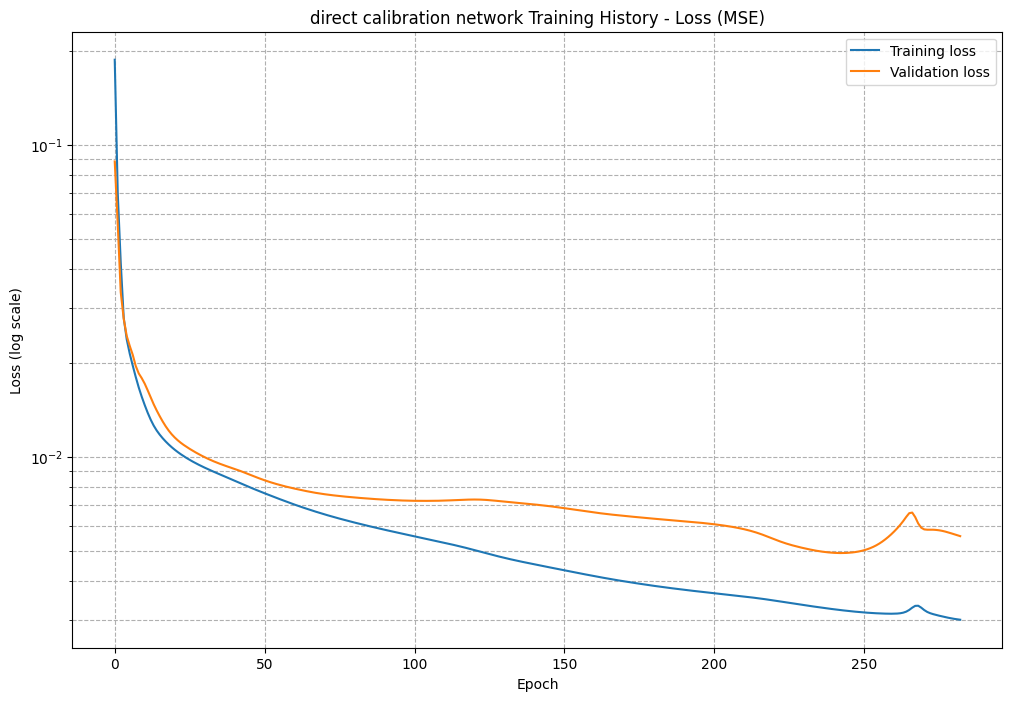


Final Training Loss: 3.0103e-03
Final Validation Loss: 5.5786e-03


In [7]:
import time
# EarlyStopping callback
earlystop = EarlyStopping(
    monitor='val_loss', 
    patience=40,       
    verbose=1,       
    restore_best_weights=True  # Restore the best model weights
)

# Callbacks
#reduce_lr = ReduceLROnPlateau(
#        monitor='val_loss',
#        factor=0.5,
#        patience=20,
#        min_lr=5e-5,
 #       verbose=1
 #   )

# Compile the model
modeldirect.compile(loss="mse", optimizer="adam")

# Train the model
start=time.time()
history = modeldirect.fit(
    x_train_transform, 
    y_train_transform, 
    batch_size=256,
    validation_data=(x_val_transform, y_val_transform),
    epochs=400, 
    verbose=1, 
    shuffle=True, 
    callbacks=[earlystop]
)
end=time.time()
training_time=(end-start)
print("Training time :" ,training_time , "s" )

# Plot training history
plt.figure(figsize=(12, 8))  
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.title('direct calibration network Training History - Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"\nFinal Training Loss: {final_train_loss:.4e}")
print(f"Final Validation Loss: {final_val_loss:.4e}")

# Interpretability analysis through SHAP Values

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


Shape of shap_exp.values: (1200, 88, 5)
Type of shap_exp.values: <class 'numpy.ndarray'>
Final shape of shap_values: (1200, 5, 88)


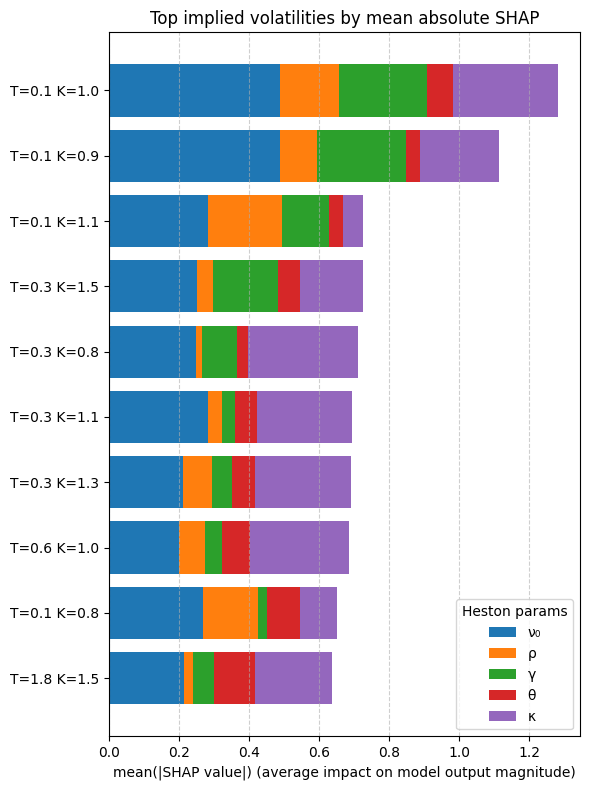

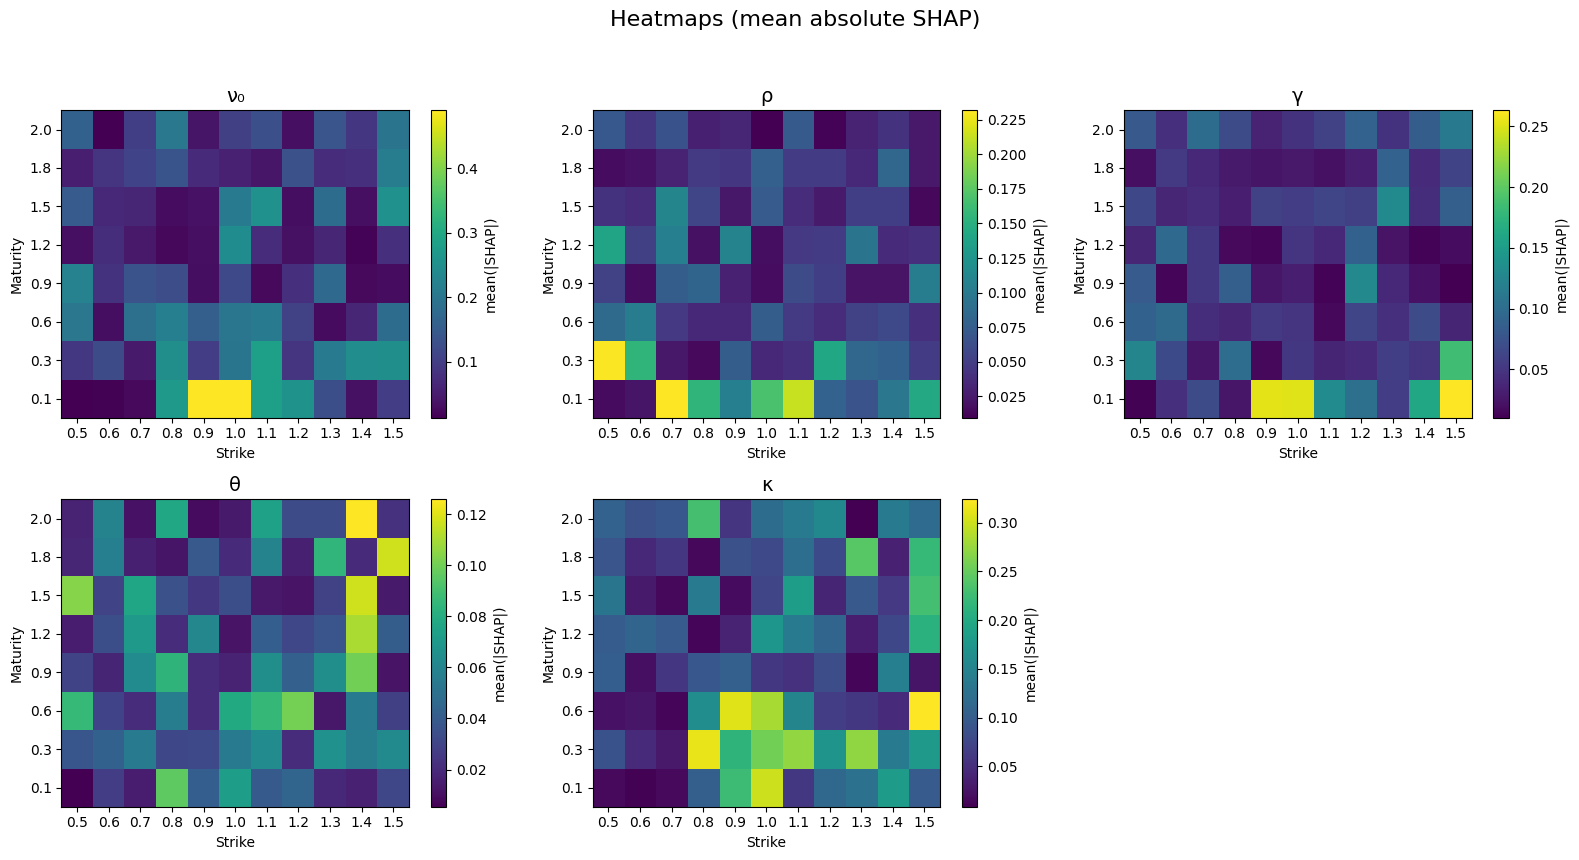

In [9]:
import shap

# --- Rewrite strikes and maturities ---
strikes = np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5])
maturities = np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0])
n_strikes, n_matur = strikes.size, maturities.size
assert n_strikes * n_matur == 88

param_names = ["ν₀", "ρ", "γ", "θ", "κ"]

# Smaller background to speed up
background = x_train_transform[np.random.choice(len(x_train_transform), size=1000, replace=False)]
background32 = background.astype(np.float32)
x_test32 = x_test_transform.astype(np.float32)

# --- GradientExplainer (without output_names) ---
explainer = shap.DeepExplainer(
    (modeldirect.input, modeldirect.output),
    background32
)

# Compute SHAP values on the test set
shap_exp = explainer(x_test32)

# Debugging: let's see the output shape
print("Shape of shap_exp.values:", np.array(shap_exp.values).shape)
print("Type of shap_exp.values:", type(shap_exp.values))

# Rearrange the dimensions to get (n_samples, n_outputs, n_features)
shap_values = shap_exp.values.transpose(0, 2, 1)  # (1200, 5, 88)

n_test, n_outputs, n_features = shap_values.shape
print(f"Final shape of shap_values: {shap_values.shape}")
assert n_outputs == len(param_names) and n_features == 88

# --- Mean absolute SHAP ---
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)   # (5,88)
total_mean_abs_shap = mean_abs_shap.sum(axis=0)

# Labels
feature_labels = []
for T in maturities:
    for K in strikes:
        feature_labels.append(f"T={T:.1f} K={K:.1f}")
feature_labels = np.array(feature_labels)

# Sorting by total importance
order = np.argsort(total_mean_abs_shap)[::-1]
sorted_labels = feature_labels[order]
sorted_per_param = mean_abs_shap[:, order]

# --- Stacked bar plot with manual colors ---
plt.figure(figsize=(6, 8))
top_N = 10
y_positions = np.arange(top_N)
bottom = np.zeros(top_N)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

for i in range(n_outputs):
    vals = sorted_per_param[i, :top_N]
    plt.barh(y_positions, vals, left=bottom, label=param_names[i], color=colors[i])
    bottom += vals

plt.yticks(y_positions, sorted_labels[:top_N])
plt.gca().invert_yaxis()
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
plt.title("Top implied volatilities by mean absolute SHAP")
plt.legend(title="Heston params")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Saliency/Heatmaps maps ---
saliency_maps = mean_abs_shap.reshape((n_outputs, n_matur, n_strikes))  # (5,8,11)

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

for i in range(n_outputs):
    ax = axes[i]
    im = ax.imshow(saliency_maps[i], origin='lower', aspect='auto', cmap="viridis")
    ax.set_title(param_names[i], fontsize=14)
    ax.set_xlabel("Strike")
    ax.set_ylabel("Maturity")
    ax.set_xticks(np.arange(n_strikes))
    ax.set_xticklabels([f"{s}" for s in strikes])
    ax.set_yticks(np.arange(n_matur))
    ax.set_yticklabels([f"{t}" for t in maturities])
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("mean(|SHAP|)")

axes[-1].axis('off')
fig.suptitle("Heatmaps (mean absolute SHAP)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Evaluate the calibration network on test data
We can already assess the performance of the calibration network, in fact since it's been trained on implied volatility surfaces, it's possible to assess the calibration performance on test data.

In [ ]:
# Calculate predictions on preprocessed test implied volatility surfaces 
start=time.perf_counter()
y_pred_transformed = modeldirect.predict(x_test_transform)
calib_time = (time.perf_counter()-start)/x_test_transform.shape[0]
print("Calibration time (per surface):" , calib_time*1000 , "ms" )

# 1) Error on preprocessed test parameters (y_test_transform)
mse_transformed = np.mean(np.square(y_test_transform - y_pred_transformed))
rmse_transformed = np.sqrt(mse_transformed)

print("\nErrors on preprocessed test data:")
print(f"- MSE: {mse_transformed:.6f}")
print(f"- RMSE: {rmse_transformed:.6f}")

# 2) Error on original scale test parameters (inverse transformed)
y_pred_original = myinverse(y_pred_transformed)

mse_original = np.mean(np.square(y_test - y_pred_original))
rmse_original = np.sqrt(mse_original)

print("\nErrors on original scale test data:")
print(f"- MSE: {mse_original:.6f}")
print(f"- RMSE: {rmse_original:.6f}")


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Calibration time : 0.12964283334440552 ms

Errors on preprocessed test data:
- MSE: 0.004053
- RMSE: 0.063663

Errors on original scale test data:
- MSE: 0.004167
- RMSE: 0.064553


# Optimizing the calibration
Numpy Implementation of the Neural Network tends to be **faster** than Keras, in this way we can evaluate in a faster and more efficient way the calibration cutting further down the calibration time.

 In particular we completely **eliminate** the Keras framework **overhead** for each predict call. 

 The following numpy implementations are specifically designed for single and batch surfaces calibration, every operation is vectorized, the batch version processes **all the surfaces at once** completely in parallel leveraging preallocation for efficient memory usage. 
 
 This leads to a **~40** faster calibration: only few µs per surface!

In [16]:
import scipy.optimize
import matplotlib.ticker as mtick

def extract_weights_from_keras_model(model):
    """
    Extract weights and bias from the trained keras network, format for Numpy usage
    """
    weights_and_biases = []
    
    # Extract weights and biases for each layer
    for layer in model.layers:
        if hasattr(layer, 'get_weights') and layer.get_weights():
            weights, biases = layer.get_weights()
            weights_and_biases.append([weights, biases])
    
    return weights_and_biases

# Extract parameters from your trained model
NNParameters = extract_weights_from_keras_model(modeldirect)

# =====================================================================================
# NUMPY IMPLEMENTATION OF THE DIRECT CALIBRATION NN (FASTER THAN KERAS)
# =====================================================================================

# Network hyperparameters
NumLayers = 4  # 4 hidden layers (30 neurons each)
InputSize = 88  # 88 volatility surface points
OutputSize = 5  # 5 Heston parameters

def elu(x):
    """
    ELU activation function
    Args:
        x: input array
    Returns:
        ELU activated array
    """
    x = np.array(x, dtype=np.float64)
    return np.where(x < 0, np.exp(x) - 1, x)

def DirectCalibrationNN(x):
    """
    Forward pass of Direct Calibration Neural Network
    
    Args:
        volatility_surfaces: arrays of 88 volatility surface points (input)
    
    Returns:
        heston_params: array of 5 Heston parameters 
    """
    # Forward pass through hidden layers with ELU activation
    for i in range(NumLayers):
        # Linear transformation: x = x * W + b
        x = np.dot(x, NNParameters[i][0]) + NNParameters[i][1]
        # ELU activation
        x = elu(x)
    
    # Output layer with tanh activation
    output = np.dot(x, NNParameters[NumLayers][0]) + NNParameters[NumLayers][1]
    output = np.tanh(output)
    
    return output

# =====================================================================================
# OPTIMIZED NUMPY IMPLEMENTATION FOR BATCH PROCESSING
# =====================================================================================

def batch_DirectCalibrationNN(volatility_surfaces):
    """
    Vectorized forward pass for batch processing
    
    Args:
        volatility_surfaces: array of shape (n_surfaces, 88) 
    Returns:
        heston_params: array of shape (n_surfaces, 5)
    """
    # Pre-allocate output array
    n_surfaces = volatility_surfaces.shape[0]
    output = np.zeros((n_surfaces, 5))
    
    # Batch processing through all layers
    x = volatility_surfaces.copy()
    for i in range(NumLayers):
        x = x @ NNParameters[i][0] + NNParameters[i][1]  # @ = matrix multiplication
        x = np.where(x < 0, np.exp(x) - 1, x)  # ELU activation
    
    # Output layer with tanh
    output = np.tanh(x @ NNParameters[NumLayers][0] + NNParameters[NumLayers][1])
    return output

# =====================================================================================
# BENCHMARKING OPTIMIZED VERSION
# =====================================================================================

def run_benchmark():
    # Warm-up runs (ensure fair timing)
    _ = batch_DirectCalibrationNN(x_test_transform[:10])
    
    # Time measurement
    start_time = time.perf_counter()
    calibrated_params = batch_DirectCalibrationNN(x_test_transform)
    total_time = (time.perf_counter() - start_time) * 1000  # Convert to ms
    
    n_surfaces = x_test_transform.shape[0]
    avg_time = total_time / n_surfaces
    
    print(f"\nBATCH CALIBRATION RESULTS (NumPy Optimized)")
    print("----------------------------------------")
    print(f"Total surfaces processed: {n_surfaces}")
    print(f"Total calibration time: {total_time:.2f} ms")
    print(f"Average time per surface: {avg_time*1000:.4f} µs")
    print(f"Throughput: {n_surfaces/(total_time/1000):.0f} surfaces/second")
    
    return calibrated_params

# Run benchmark
final_calibrated_params = run_benchmark()


BATCH CALIBRATION RESULTS (NumPy Optimized)
----------------------------------------
Total surfaces processed: 1200
Total calibration time: 4.13 ms
Average time per surface: 3.4443 µs
Throughput: 290332 surfaces/second


In [13]:
# COMPARISON KERAS VS NUMPY IMPLEMENTATION
# Generate predictions with both methods
keras_pred = modeldirect.predict(x_test_transform, verbose=0)
numpy_pred = batch_DirectCalibrationNN(x_test_transform)

# Compute absolute and relative differences
abs_diff = np.abs(keras_pred - numpy_pred)
rel_diff = abs_diff / (np.abs(keras_pred) + 1e-12)  # Avoid dividing by 0

# Stats
print("Compare predictions Keras vs NumPy:")
print(f"Max absolute difference: {np.max(abs_diff):.2e}")
print(f"Mean relative difference: {np.mean(rel_diff):.2%}")
print(f"Positions with >1% difference: {np.sum(rel_diff > 0.01)}/{rel_diff.size}")
print("Numpy and Keras predictions agree ✔")

Compare predictions Keras vs NumPy:
Max absolute difference: 3.22e-15
Mean relative difference: 0.00%
Positions with >1% difference: 0/6000
Numpy and Keras predictions agree ✔


# Complete test analysis

Surfaces parameters shape: (1200, 5)


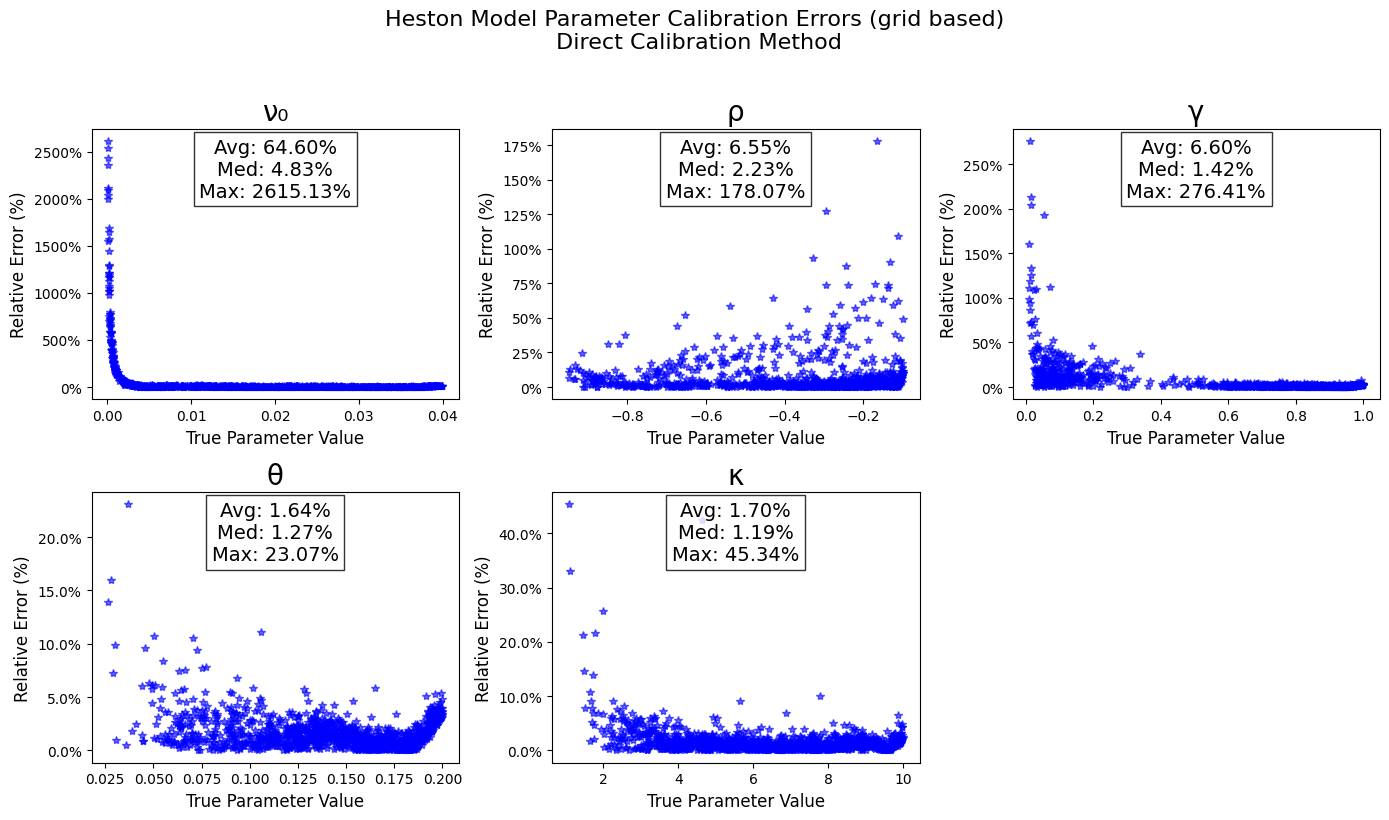


Summary Statistics of Relative Errors (%):
ν₀: Avg=64.60%, Med=4.83%, Max=2615.13%
ρ: Avg=6.55%, Med=2.23%, Max=178.07%
γ: Avg=6.60%, Med=1.42%, Max=276.41%
θ: Avg=1.64%, Med=1.27%, Max=23.07%
κ: Avg=1.70%, Med=1.19%, Max=45.34%


In [14]:
# Convert predictions to original scale
print(f"Surfaces parameters shape: {numpy_pred.shape}")  # Should be (1200,5)
calib_params = myinverse(numpy_pred)

# Verify dimensions
assert len(calib_params) == len(y_test), "Mismatch between calibrated parameters and test set"

# Plot relative errors for each parameter
titles = ["ν₀", "ρ", "γ", "θ", "κ"]
relative_errors = np.zeros((len(calib_params), 5))  # Store all relative errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(5):
    ax = plt.subplot(2, 3, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = y_test[:, param_idx]
    calibrated_params = calib_params[:, param_idx]
    
    # Calculate relative errors 
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_errors = np.abs(calibrated_params - true_params) / np.abs(true_params)
    
    relative_errors[:, param_idx] = rel_errors
    
    # Plot
    plt.plot(true_params, 100 * rel_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add statistics
    stats_text = 'Avg: %1.2f%%\nMed: %1.2f%%\nMax: %1.2f%%' % (
        np.mean(100 * rel_errors),
        np.median(100 * rel_errors),
        np.max(100 * rel_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('Heston Model Parameter Calibration Errors (grid based)\n Direct Calibration Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Relative Errors (%):")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(100*relative_errors[:,i]):.2f}%, "
          f"Med={np.median(100*relative_errors[:,i]):.2f}%, "
          f"Max={np.max(100*relative_errors[:,i]):.2f}%")

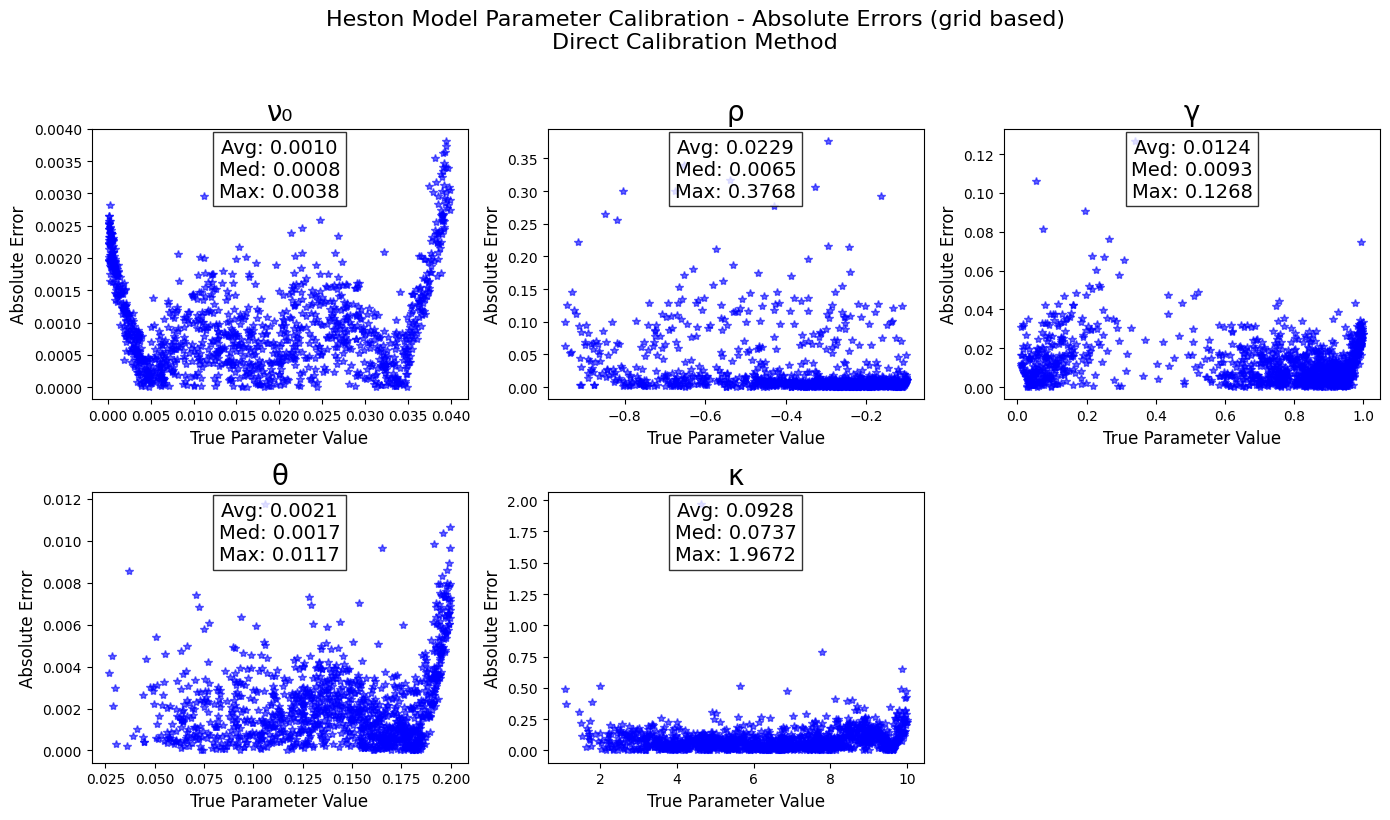


Summary Statistics of Absolute Errors:
ν₀: Avg=0.000969, Med=0.000805, Max=0.003813
ρ: Avg=0.022948, Med=0.006525, Max=0.376835
γ: Avg=0.012445, Med=0.009310, Max=0.126833
θ: Avg=0.002116, Med=0.001693, Max=0.011743
κ: Avg=0.092844, Med=0.073692, Max=1.967207


In [15]:
# Correct parameter names and absolute error analysis
titles = ["ν₀", "ρ", "γ", "θ", "κ"]
absolute_errors = np.zeros((len(calib_params), 5))  # Store all absolute errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(5):
    ax = plt.subplot(2, 3, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = y_test[:, param_idx]
    calibrated_params = calib_params[:, param_idx]
    
    # Calculate absolute errors
    abs_errors = np.abs(calibrated_params - true_params)
    absolute_errors[:, param_idx] = abs_errors
    
    # Plot
    plt.plot(true_params, abs_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    
    # Add statistics
    stats_text = 'Avg: %1.4f\nMed: %1.4f\nMax: %1.4f' % (
        np.mean(abs_errors),
        np.median(abs_errors),
        np.max(abs_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('Heston Model Parameter Calibration - Absolute Errors (grid based)\nDirect Calibration Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Absolute Errors:")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(absolute_errors[:,i]):.6f}, "
          f"Med={np.median(absolute_errors[:,i]):.6f}, "
          f"Max={np.max(absolute_errors[:,i]):.6f}")